In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *


module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from plot_utils import *
configure_plot(plt)

In [3]:
NPOINTS = 23
MULT_UB = 3
MULT_LB = 1

In [4]:
lockdown_matrix_str = \
"""6.25	2	0.05	0.05	0	0	0	0.02
1.70	4	0.05	0.05	0	0	0	0.04
0.09	0.11	2	0.05	0	0	0	0.36
0.07	0.08	0.04	4.5	0	0	0	0.04
0.00	0.00	0.00	0.00	0.5	0.075	0.15	0.78
0.00	0.00	0.00	0.00	0.14	0.9	0.1	0.78
0.00	0.00	0.00	0.00	0.11	0.04	0.9	0.78
0.002	0.005	0.021	0.003	0.045	0.024	0.060	3.5"""

lockdown_matrix = np.array([[float(entry) for entry in line.split('\t')] for line in lockdown_matrix_str.split('\n')])

In [5]:
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)
centre = get_centre_point()


In [6]:
def run_multigroup_sim(sim, T):
    lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)
    popsize = sim.get_total_population()
    infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list, lockdown_statuses, list(infection_counts)

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    lockdown_trajectories = []
    infection_trajectories = []
    for _ in range(n):
        inf, hosp, lockdowns, infections = run_multigroup_sim(sim, T)
        inf_matrix.append(inf)
        hosp_matrix.append(hosp)
        lockdown_trajectories.append(lockdowns)
        infection_trajectories.append(infections)
    return inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories

def evaluate_testing_policy_v2(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window):
    assert len(params_list) == len(test_frac)
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, [True] * 7 + [False], new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return lockdown_trajectories, infection_trajectories

def simulate_lockdown_v2(params, infections_thresh, infections_window, nreps=10):
    simulation_population = 90890
    new_cases_thresh = infections_thresh
#     new_cases_thresh = infections_thresh / simulation_population
    test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    
    processed_params, _ = uncertainty_point_to_params_dict(params)
    
    params_dict = processed_params[0]
    interaction_matrix = processed_params[1]
    group_names = processed_params[2]
    
    for idx, param in enumerate(params_dict):
        param['expected_contacts_per_day'] = interaction_matrix[idx, idx]
    
    return evaluate_testing_policy_v2(params_dict,
                                      interaction_matrix,
                                      group_names,
                                      test_policy,
                                      112,
                                      nreps,
                                      lockdown_matrix,
                                       new_cases_thresh,
                                       infections_window)

In [7]:
params_dict, _ = uncertainty_point_to_params_dict(centre)
total_popsize = 0
for subparams in params_dict[0]:
    total_popsize += subparams['population_size']
print(total_popsize)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


90890


In [8]:
import multiprocessing, time

def run_sim_wrapper(params, infections_thresh, infections_window,
                    proc_key, nreps, random_seed, return_dict):
    np.random.seed(random_seed)
    lockdowns, final_infections = simulate_lockdown_v2(params, 
                                                    infections_thresh, 
                                                    infections_window,
                                                    nreps=nreps)
    return_dict[proc_key] = {'lockdown_pct': lockdowns,
                            'final_infection_pct': final_infections}
    

BASE_SEED = 1000000
    
def simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    jobs = []
    
    base_seed = np.random.randint(1000000, 10000000)

    params_list = get_points_on_line(centre, res_pessimistic, npoints=NPOINTS, mult_lb=MULT_LB, mult_ub=MULT_UB)
    for idx, params in enumerate(params_list):
        print(idx+base_seed)
        p = multiprocessing.Process(target = run_sim_wrapper,
                                   args = (params, infections_thresh, infections_window, idx, nreps, 
                                           idx + base_seed, return_dict))
        jobs.append(p)
        p.start()

    for p in jobs:
        p.join()
    
    return return_dict


In [9]:
nreps = 150
return_dicts = {}
infection_thresholds = [150,200,250,300,350]
infection_windows = [7]


import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


5793191
5793192
5793193
5793194
5793195
5793196
5793197
5793198
5793199
5793200
5793201
5793202
5793203
5793204
5793205
5793206
5793207
5793208
5793209
5793210
5793211
5793212
5793213
done simulating (150, 7) in 1060.66 seconds
8726829
8726830
8726831
8726832
8726833
8726834
8726835
8726836
8726837
8726838
8726839
8726840
8726841
8726842
8726843
8726844
8726845
8726846
8726847
8726848
8726849
8726850
8726851
done simulating (200, 7) in 1052.90 seconds
9737628
9737629
9737630
9737631
9737632
9737633
9737634
9737635
9737636
9737637
9737638
9737639
9737640
9737641
9737642
9737643
9737644
9737645
9737646
9737647
9737648
9737649
9737650
done simulating (250, 7) in 1067.24 seconds
6543171
6543172
6543173
6543174
6543175
6543176
6543177
6543178
6543179
6543180
6543181
6543182
6543183
6543184
6543185
6543186
6543187
6543188
6543189
6543190
6543191
6543192
6543193
done simulating (300, 7) in 1056.44 seconds
2708734
2708735
2708736
2708737
2708738
2708739
2708740
2708741
2708742
2708743
2708744


In [9]:
sorted(return_dict.keys()


SyntaxError: unexpected EOF while parsing (<ipython-input-9-ab6aae355ac3>, line 1)

In [11]:
return_dicts.keys()

dict_keys([(150, 7), (200, 7), (250, 7), (300, 7), (350, 7)])

In [11]:
np.linspace(0,1.5,13)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  ])

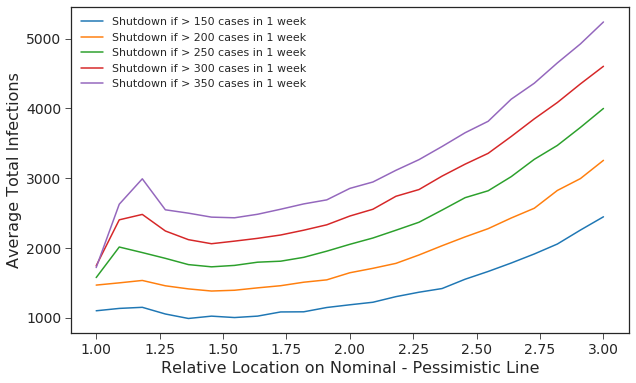

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# def configure_plot(plt):
#     plt.style.use('seaborn-ticks')
#     plt.rcParams['axes.titlesize'] = 20
#     plt.rcParams['axes.labelsize'] = 16
#     plt.rcParams['legend.fontsize'] = 14
#     plt.rcParams['xtick.labelsize'] = 14
#     plt.rcParams['ytick.labelsize'] = 14
# configure_plot(plt)

plt.figure(figsize=(10,6))

centre_pess_indices = list(range(NPOINTS))
centre_pess_mults = np.linspace(MULT_LB,MULT_UB,NPOINTS)

keys = list(return_dicts.keys())

xlabel_mults = centre_pess_mults

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in centre_pess_indices:
        infections.append(np.mean([inf[-1] / 100 * total_popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Relative Location on Nominal - Pessimistic Line")
plt.ylabel("Average Total Infections")
#plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best', fontsize=11)

#plt.savefig('res_inst_paper_graphs/mar_19_graphs/shutdown_infections.png', dpi=450)

([<matplotlib.axis.XTick at 0x7fafac58c490>,
 <a list of 3 Text xticklabel objects>)

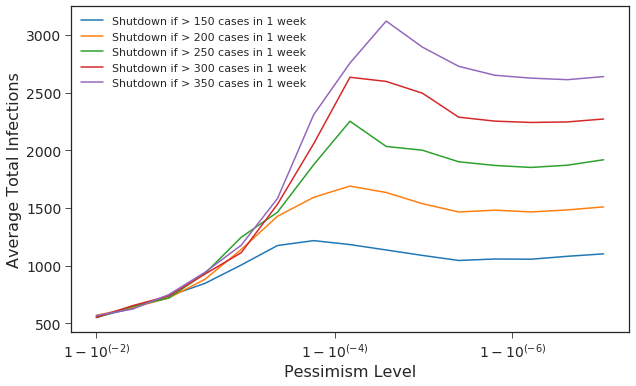

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

centre_pess_indices = list(range(NPOINTS))
centre_pess_mults = np.linspace(MULT_LB,MULT_UB,NPOINTS)

keys = list(return_dicts.keys())

xlabel_mults = centre_pess_mults
# Note 1 corresponds to pessimisitic, not z-score
x_vals = [norm.ppf(0.99) * x for x in xlabel_mults]

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in centre_pess_indices:
        infections.append(np.mean([inf[-1] / 100 * total_popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(x_vals[:15], infections[:15], label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Pessimism Level")
plt.ylabel("Average Total Infections")
#plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best', fontsize=11)

plotting_quantiles = [0.99, 0.9999, 0.999999]
plotting_labels = ['$1-10^{(-2)}$', '$1-10^{(-4)}$', '$1-10^{(-6)}$']
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_labels)

# plt.xlim([norm.ppf(0.99), norm.ppf(0.999999)])

#plt.savefig('res_inst_paper_graphs/mar_19_graphs/shutdown_infections.png', dpi=450)

In [30]:
centre_pess_mults[:15]

array([1.        , 1.09090909, 1.18181818, 1.27272727, 1.36363636,
       1.45454545, 1.54545455, 1.63636364, 1.72727273, 1.81818182,
       1.90909091, 2.        , 2.09090909, 2.18181818, 2.27272727])

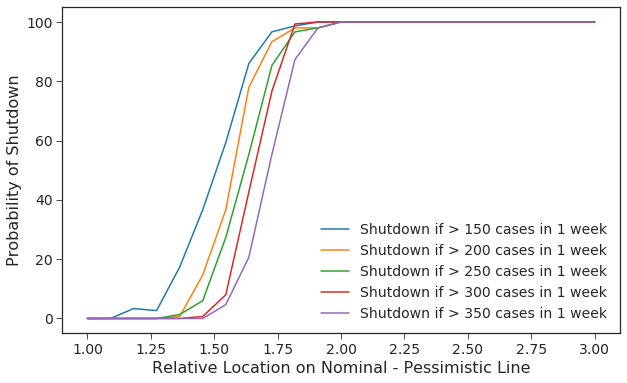

In [24]:
plt.figure(figsize=(10,6))
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in centre_pess_indices:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Relative Location on Nominal - Pessimistic Line")
plt.ylabel("Probability of Shutdown")
#plt.title("Shutdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best')


([<matplotlib.axis.XTick at 0x7fafac4cd690>,
 <a list of 3 Text xticklabel objects>)

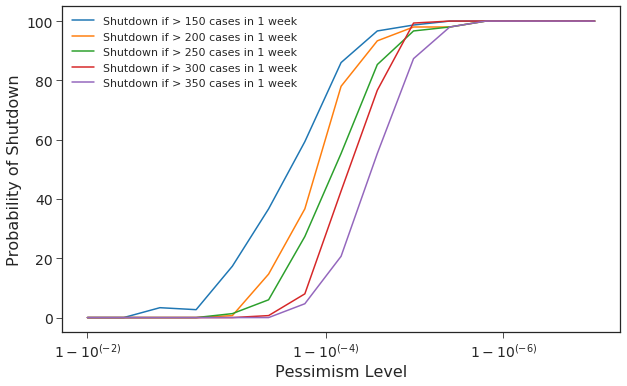

In [40]:
plt.figure(figsize=(10,6))
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in centre_pess_indices:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(x_vals[:15], lockdowns[:15], label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Pessimism Level")
plt.ylabel("Probability of Shutdown")
#plt.title("Shutdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best', fontsize=11)

plotting_quantiles = [0.99, 0.9999, 0.999999]
plotting_labels = ['$1-10^{(-2)}$', '$1-10^{(-4)}$', '$1-10^{(-6)}$']
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_labels)
